In [1]:
# Iniciando Ambiente
import numpy as np
import datetime as dt

import nltk

# Se necessário, descomente as linhas a seguir para ler as stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

import unicodedata
import re 

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
diretorio = "F:\\Weisner\\Documentos\\MEGA Estudos\\UNB - MDM - Mineração de Dados Massivos\\Artigo\\"  

In [4]:
arquivo   = "Base_1milhão.xlsx"
stopwords = set(stopwords.words('portuguese') )

In [5]:
listaRetiraInicio = [] # ['BB','Z ', 'MC ']
listaRetiraFim    = [] # [' CC']
listaCaracteresIndesejados = ["	", # tabulação
                              "*",
                              "#",
                              "|",
                              '¥'
                             ]

In [ ]:
############## Leitura e "anonimização" da planilha de dados - INICIO ##############

In [ ]:
# Lê df_original da planilha do excel
    
df_original = pd.read_excel(diretorio + arquivo, sheet_name='Catalogo1')

In [ ]:
# Salva em arquivo binário o df_original
df_original.to_pickle("./df_original.pkl")

In [6]:
# Lê o arquivo binário do df_original
df_original = pd.read_pickle("./df_original.pkl")

In [7]:
# Cria a lista de nomes anônimos
qtdRemetente = len(df_original['Nome'].unique())
listaAnonima = []
for i in range(1,qtdRemetente+1):
    if i in range(1,10):
        listaAnonima.append( 'Fornecedor 00' + str(i) )
    elif i in range(10,100):
            listaAnonima.append( 'Fornecedor 0' + str(i) )    
    else:
        listaAnonima.append( 'Fornecedor ' + str(i) )
        
# Cria lista de fornecedores reais
listaNomes = list(df_original['Nome'].unique())    

# Cria DF de remetentes e seu anônimo
dfRemetenteAnonimo = pd.DataFrame( )
dfRemetenteAnonimo['Nome'] = listaNomes
dfRemetenteAnonimo['Remetente_Anonimo'] = listaAnonima
dfRemetenteAnonimo

# Salva em arquivo o dfRemetenteAnonimo
dfRemetenteAnonimo.to_pickle("./dfRemetenteAnonimo.pkl")
#dfRemetenteAnonimo = pd.read_pickle("dfRemetenteAnonimo.pkl")

# Cria dicionário de fornecedores
dicFornecedores = dict(zip(listaNomes, listaAnonima))

# gera lista de fornecedores anonimizados para cada descrição de produto
fornecedoresAnonimos = list( map(lambda x: dicFornecedores[x], list(df_original['Nome']) ) )

# Substitui o nome do remetente por seu anonimo
df_original['Nome'] = fornecedoresAnonimos

In [ ]:
df_original

In [9]:
del qtdRemetente, listaAnonima, i, listaNomes, dfRemetenteAnonimo, dicFornecedores

In [10]:
# Salva em arquivo binário o df_original
df_original.to_pickle("./df_originalAnonimo.pkl")

In [ ]:
############## Leitura e "anonimização" da planilha de dados - FIM ##############

In [ ]:
# Lê o arquivo binário do df_original
df_original = pd.read_pickle("./df_original.pkl")

In [12]:
# retira stop words do nome dos usuários reais
def limpaTexto( entrada ):
    
    # PROBLEMA: TEM QUE VERIFICAR A LISTA DE STOPWORDS PARA QUE ELA 
    # NÃO RETIRE DESCRIÇÃO VÁLIDA DE PRODUTOS.
    # retira stopwords
    entrada = str(entrada)
    entrada = entrada.split(" ")
    saida = ""
    for item in entrada:
        if item.lower() not in stopwords:
            saida = saida + item + " "
    
    # retira acentos
    aux   = str(saida)
    nfkd  = unicodedata.normalize('NFKD', aux)
    saida = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    
    # transforma em maiúsculo, retira espaços dos extremos (TRIM), 
    saida = saida.upper().strip()
    
    # retira caracteres indesejados --> cuidado para não unir palavras separadas pelo caracter
    for item in listaCaracteresIndesejados:
        saida = saida.replace(item,"")    
    
    # retira espaços duplos dentro da string
    saida = saida.replace("  "," ")
    while saida.find('  ') != -1:
        saida = saida.replace("  "," ")
              
    # retira inicios de strings que constam na lista listaRetiraInicio
    for item in listaRetiraInicio:
        # retira espaços duplos dentro do item, pois o mesmo já foi feito no texto a pesquisar
        item = item.replace("  "," ")
        while item.find('  ') != -1:
            item = item.replace("  "," ")
            
        if saida.startswith(item):
            tamanhoItem  = len(item)
            tamanhoSaida = len(saida)            
            if tamanhoSaida > tamanhoItem:
                saida = saida[tamanhoItem:]
    
    # retira fins de strings que constam na lista listaRetiraFim
    for item in listaRetiraFim:
        # retira espaços duplos dentro do item, pois o mesmo já foi feito no texto a pesquisar
        item = item.replace("  "," ")
        while item.find('  ') != -1:
            item = item.replace("  "," ")        
        
        if saida.endswith(item):
            tamanhoItem  = len(item)
            tamanhoSaida = len(saida)
            if tamanhoSaida > tamanhoItem:
                saida = saida[:tamanhoSaida-tamanhoItem]   



    # retira espaços duplos dentro da string. Necessário pois pode ter sobrado 
    # espaço depois das alterações
    saida = saida.strip()
        
    return saida 

In [13]:
# Somente para teste da rotina de limpa texto
resp = limpaTexto('00000lf1412214')
resp

'00000LF1412214'

In [14]:
# Insere coluna "NovaDescricao" com as descrições tratadas 
novadescricao = map( limpaTexto, df_original['Desc_Catalogo'] ) 
df_original.insert( loc = 2, column = "NovaDescricao", value = list(novadescricao))#, allow_duplicates = False)
del novadescricao

In [15]:
# Apaga linhas cuja coluna 'NovaDescricao' esteja em branco
df_original['NovaDescricao'].dropna( axis=0, inplace=True )  

In [16]:
# Concatena 3 colunas para formar a coluna 'Categoria', que é a classificação do produto
df_original['Categoria'] = df_original['Item_Anexo_IV'].astype(str) + df_original['Prod_ST'] + df_original['Prod_FCP']

In [17]:
# Apaga colunas que não serão usadas
df_original.drop(['Desc_Catalogo', 'NCM_NFe', 'Desc_Anexo_IV', 'NCM_Calc_Prov', 'Cor_NCM_Calc', 'NCM_Calc', 
         'Item_Anexo_IV', 'Prod_ST', 'Prod_FCP'], axis=1, inplace=True)

In [18]:
# Renomeia as colunas do DF
df_original.columns = ('Remetente','NovaDescricao','Categoria')

 Elimina linhas inconsistentes, repetidas. Mantém a primeira delas

In [19]:
antes = df_original.shape[0]
df_original.drop_duplicates( subset = ["NovaDescricao"], inplace = True) 
print( 'Eliminados', antes - df_original.shape[0], 'registros')
del antes

Eliminados 15719 registros


In [20]:
# Retira categorias indesejadas
retirar = ['nannãonão','nansimnão','nansimsim']
mask = ~df_original['Categoria'].isin(retirar)
filtrado = df_original[mask].copy()
df_original = filtrado.copy()
del filtrado, retirar

In [21]:
# Cria o DF com os dados obtidos da base a ser trabalhada, já ajustada. 
# O df_original fica com backup, durante o desenvolimento porque a base demora para ser lida.

df = df_original.copy()

In [ ]:
########################  CRIA LISTA DE PALAVRAS, COM CÁLCULO DO Nº DE REPETIÇÃO - INICIO ##########################

In [22]:
# Gera lista com todas as palavras, com repetições
# CountVectorizer retira duplicidade
total_linhas = df.shape[0]
lista_palavras = []
for i in range(0,total_linhas):
    texto = df.iloc[i, 1].split()
    tamanho_linha = len(texto)
    for j in range(0,tamanho_linha):
        lista_palavras.append( texto[j]) 
        
# Gera DF com a contagem de cada palavra
lista_palavras = pd.Series(data = lista_palavras)
df_lista_palavras = pd.DataFrame(data = lista_palavras.value_counts() )#, index = lista_palavras)
df_lista_palavras.reset_index(drop = False, inplace = True)
df_lista_palavras.columns = ['Palavra','QTD']

#libera memoria
del total_linhas, lista_palavras, texto, tamanho_linha,

In [23]:
########################  CRIA LISTA DE PALAVRAS, COM REPETIÇÃO - FIM ##########################

In [24]:
Lista_palavras_eliminar = []

In [25]:
########### elimina palavras de 1 caracter

mask = (df_lista_palavras['Palavra'].str.len() == 1)
df_aux = df_lista_palavras[mask]
Lista_palavras_eliminar = Lista_palavras_eliminar + list(df_aux['Palavra'])
mask = ~(df_lista_palavras['Palavra'].str.len() == 1)
df_aux = df_lista_palavras[mask]
df_lista_palavras = df_aux.copy()

del df_aux, mask

In [26]:
########### elimina palavras que são somente numeros, exceto os de 13 algarismos ( possíveis EAN)

# Separa possíveis códigos EAN
mask1 = df_lista_palavras.Palavra.str.len() == 13
mask2 = df_lista_palavras.Palavra.str.isdigit()
df_aux = df_lista_palavras[~(mask1 & mask2)]
# elimina números
mask2 = df_aux.Palavra.str.isdigit()
df_aux = df_aux[mask2]

Lista_palavras_eliminar = Lista_palavras_eliminar + list(df_aux['Palavra'])
mask = ~df_lista_palavras['Palavra'].isin( list(df_aux['Palavra']) )
df_aux = df_lista_palavras[mask]
df_lista_palavras = df_aux.copy()
del df_aux, mask1, mask2

In [27]:
def EliminaPalavrasVindasDeArquivo( nome_arquivo ):
    global Lista_palavras_eliminar
    global df_lista_palavras
    df_aux = pd.read_csv(nome_arquivo, index_col = ['Indice'], sep = ';',)
    Lista_palavras_eliminar = Lista_palavras_eliminar + list(df_aux['Palavra'])
    mask = ~df_lista_palavras['Palavra'].isin( list(df_aux['Palavra']) )
    df_aux = df_lista_palavras[mask]
    df_lista_palavras = df_aux.copy()
    del df_aux, mask

Trata palavras terminadas com ML (mililitros) - INICIO 

In [28]:
mask1  = df_lista_palavras['Palavra'].str.endswith('ML')
mask2  = df_lista_palavras['Palavra'].str.len() < 80
mask3  = df_lista_palavras['QTD'] > 10 
df_aux = df_lista_palavras[ mask1 & mask2 & mask3 ]

df_aux.to_csv("ETL_ML_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
del df_aux, mask1, mask2, mask3

In [29]:
# SOMENTE EXECUTE ESTA CELULA DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO

EliminaPalavrasVindasDeArquivo( "ETL_ML_verificado.csv" )

Trata palavras terminadas com ML (mililitros) - FIM 

Trata palavras pela quantidade delas - INICIO 

In [30]:
mask  = df_lista_palavras['QTD'] > 1000 
df_aux = df_lista_palavras[ mask ]

df_aux.to_csv("ETL_QUANTIDADE_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
del df_aux, mask

In [31]:
# SOMENTE EXECUTE ESTA CELULAR DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO

EliminaPalavrasVindasDeArquivo( "ETL_QUANTIDADE_verificado.csv" )

Trata palavras pela quantidade delas - FIM 

Trata palavras terminadas com KG  - INICIO

In [32]:
mask1  = df_lista_palavras['Palavra'].str.endswith('KG')
mask2  = df_lista_palavras['Palavra'].str.len() < 80
mask3  = df_lista_palavras['QTD'] > 10 
df_aux = df_lista_palavras[ mask1 & mask2 & mask3 ]

df_aux.to_csv("ETL_KG_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
del df_aux, mask1, mask2, mask3

In [33]:
# SOMENTE EXECUTE ESTA CELULAR DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO

EliminaPalavrasVindasDeArquivo( "ETL_KG_verificado.csv" )

Trata palavras terminadas com KG  - FIM  

Trata palavras terminadas com GR  - INICIO

In [34]:
mask1  = df_lista_palavras['Palavra'].str.endswith('GR')
mask2  = df_lista_palavras['Palavra'].str.len() < 80
mask3  = df_lista_palavras['QTD'] > 10 
df_aux = df_lista_palavras[ mask1 & mask2 & mask3 ]

df_aux.to_csv("ETL_GR_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
del df_aux, mask1, mask2, mask3

In [35]:
# SOMENTE EXECUTE ESTA CELULAR DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO

EliminaPalavrasVindasDeArquivo( "ETL_GR_verificado.csv" )

Trata palavras terminadas com GR  - FIM 

Trata palavras terminadas com GRAMAS  - INICIO

In [36]:
mask1  = df_lista_palavras['Palavra'].str.endswith('GRAMAS')
mask2  = df_lista_palavras['Palavra'].str.len() < 80
mask3  = df_lista_palavras['QTD'] > 10 
df_aux = df_lista_palavras[ mask1 & mask2 & mask3 ]

if df_aux.shape[0] > 1:
    df_aux.to_csv("ETL_GRAMAS_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
else:
    print( 'Não há palavras terminadas com esta opcao, ou há somente uma.' )
del df_aux, mask1, mask2, mask3

Não há palavras terminadas com esta opcao, ou há somente uma.


In [ ]:
# SOMENTE EXECUTE ESTA CELULAR DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO.

#EliminaPalavrasVindasDeArquivo( "ETL_GRAMAS_verificado.csv" )

Trata palavras terminadas com GRAMAS  - FIM

Trata palavras terminadas com GRAMA  - INICIO

In [37]:
mask1  = df_lista_palavras['Palavra'].str.endswith('GRAMA')
mask2  = df_lista_palavras['Palavra'].str.len() < 80
mask3  = df_lista_palavras['QTD'] > 10 
df_aux = df_lista_palavras[ mask1 & mask2 & mask3 ]

if df_aux.shape[0] > 1:
    df_aux.to_csv("ETL_GRAMA_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
else:
    print( 'Não há palavras terminadas com esta opcao, ou há somente uma.' )
del df_aux, mask1, mask2, mask3

Não há palavras terminadas com esta opcao, ou há somente uma.


In [ ]:
# SOMENTE EXECUTE ESTA CELULAR DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO

#EliminaPalavrasVindasDeArquivo( "ETL_GRAMA_verificado.csv" )

Trata palavras terminadas com GRAMA  - FIM

Trata palavras terminadas com G  - INICIO

In [38]:
mask1  = df_lista_palavras['Palavra'].str.endswith('G')
mask2  = df_lista_palavras['Palavra'].str.len() < 80
mask3  = df_lista_palavras['QTD'] > 10 
df_aux = df_lista_palavras[ mask1 & mask2 & mask3 ]

if df_aux.shape[0] > 1:
    df_aux.to_csv("ETL_G_a_verificar.csv", index = True, columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")
else:
    print( 'Não há palavras terminadas com esta opcao, ou há somente uma.' )
del df_aux, mask1, mask2, mask3

In [39]:
# SOMENTE EXECUTE ESTA CELULAR DEPOIS DE VERIFICAR MANUALMENTE O ARQUIVO

EliminaPalavrasVindasDeArquivo( "ETL_G_verificado.csv" )

Trata palavras terminadas com G  - FIM

### Salva dados - inicio

In [40]:
# Salva as palavras da base, já com as devidas retiradas de palavras
df_lista_palavras.to_csv("ETL_base_lista_palavras_corretas.csv", index = True, 
                         columns = ["Palavra", "QTD"], sep = ';', encoding = "utf-8")

df_lista_palavras.to_pickle("./ETL_base_lista_palavras_corretas.pkl")

In [41]:
# Salva a lista de palavras que devem ser retiradas da base
pd.Series( Lista_palavras_eliminar ).to_csv("ETL_base_lista_palavras_a_retirar.csv", index = True, header = False,
                                            sep = ';', encoding = "utf-8")



### Salva dados - fim

### Elimina palavras indesejadas - INICIO

In [158]:
palavraPermitida = df_lista_palavras['Palavra']

In [159]:
dicPermitido = dict(zip(palavraPermitida, palavraPermitida))

In [148]:
def verificaDescricao(frase):
    global dicPermitido
    
    resp = ''
    frase = frase.split(" ")
    for palavra in frase:
        resp = resp + " " + dicPermitido.get(palavra,'')
    resp = resp.strip()
    resp = resp.replace("  "," ")
    return resp    

In [160]:
aux = list( map(lambda x: verificaDescricao(x), list(df_original['NovaDescricao']) ) )

In [161]:
df_original['NovaDescricao'] = aux

### Elimina palavras indesejadas - FIM

In [166]:
df_original.to_pickle("./ETL_base_pronta_para_previsao.pkl")

In [169]:
df_original['Categoria'].value_counts()

41.0simnão    161005
40.0simnão    127642
38.0simnão     94179
42.0simnão     78789
31.0simsim     57000
38.0simsim     42003
40.0nãonão     41739
38.0nãonão     41409
39.0simnão     39237
41.0nãonão     23224
39.0nãonão      5457
42.0nãonão      4956
30.0simsim      3090
31.0nãonão       182
30.0nãonão         9
Name: Categoria, dtype: int64

<AxesSubplot:>

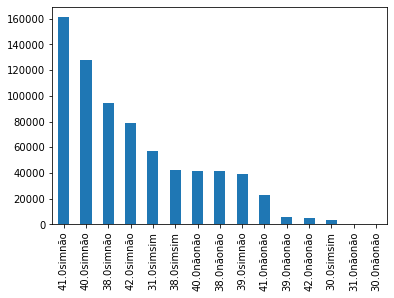

In [170]:
%matplotlib inline
df_original['Categoria'].value_counts().plot.bar()

In [171]:
from sklearn.model_selection import train_test_split
##from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import sklearn

In [172]:
# Função para avaliação dos modelos

def avalia_modelo(clf, X, y):
    resultados = sklearn.model_selection.cross_val_predict(clf, X, y, cv=5)
    # print( pd.crosstab(y, resultados, rownames=['Real'], colnames=['Predito'], margins=True))
    return np.mean(sklearn.model_selection.cross_val_score(clf, X, y, cv=5))

In [173]:
# Obtem lista de fornecedores com mais de 10000 itens
fornecedores = df['Remetente'].value_counts()
mask = fornecedores > 10000
fornecedores = list(fornecedores[mask].index)

In [174]:
len( fornecedores )

22

In [175]:
df_resultado     = [ [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] ]
for i in range( len( fornecedores ) ):
    df_resultado.append( [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan ] )


In [178]:
fornecedores

['Fornecedor 001',
 'Fornecedor 116',
 'Fornecedor 003',
 'Fornecedor 138',
 'Fornecedor 031',
 'Fornecedor 047',
 'Fornecedor 075',
 'Fornecedor 033',
 'Fornecedor 153',
 'Fornecedor 121',
 'Fornecedor 163',
 'Fornecedor 165',
 'Fornecedor 014',
 'Fornecedor 097',
 'Fornecedor 006',
 'Fornecedor 159',
 'Fornecedor 108',
 'Fornecedor 182',
 'Fornecedor 158',
 'Fornecedor 155',
 'Fornecedor 036',
 'Fornecedor 011']

In [181]:
df = df_original.copy()

In [182]:
# cria o df de resultados
colunas = [ 'Remetente','registros1','precisao1','registros2','precisao2','registros3','precisao3','registros4','precisao4' ]
#df_resultado = [] #pd.DataFrame(columns = colunas)

for fonteDados in range(0,2):
    # fonteDados = 0 --> dados com as palavras separadas manualmente
    # fonteDados = 1 --> dados sem as palavras separadas manualmente
    
    linha  = 0
    coluna = 0

    # retira as palavras separadas manualmente
#    if fonteDados == 10:
#        print( )
#        print('Sem palavras selecionadas manualemnte.')
#        print()
#        
#        # Lê o arquivo de paravras indesejadas 
#        df_palavras_a_eliminar = pd.read_csv('ETL_base_lista_palavras_a_retirar_minusculas.csv', sep=";")
#        from nltk.corpus import stopwords
#        stopwords = set( stopwords.words('portuguese') + list( df_palavras_a_eliminar['palavra'] ) )
#
#        # retira as palavras indesejadas do df
#        novadescricao = map( limpaTexto2, df['NovaDescricao'] ) 
#        df.insert( loc = 2, column = "NovaDescricao2", value = list(novadescricao))#, allow_duplicates = False)
#        del novadescricao 
#        del df['NovaDescricao']
#        df.columns = ['Remetente', 'NovaDescricao', 'Categoria']  
        
#        linha  = 0
#        coluna = 4
        
    # Cria um Pipeline - Classificador Composto
    # vectorizer => transformer => classifier 
    text_clf = Pipeline([('counts' , CountVectorizer() ),
                       #  ('tfidf', TfidfTransformer()),
                         ('classifier'  , MultinomialNB()   ),
                        ])
    
    # registra resultados
    df_resultado[linha][          0] = 'Todos'
    df_resultado[linha][ coluna + 1] = df.shape[0]
    df_resultado[linha][ coluna + 2] = avalia_modelo(text_clf, df['NovaDescricao'], df['Categoria'])
    
    print(linha,' : ',coluna+1)
    print( df_resultado[linha][          0] )
    print( df_resultado[linha][ coluna + 1] )
    print( df_resultado[linha][ coluna + 2] )
    print()
    
    # Cria um Pipeline - Classificador Composto
    # vectorizer => transformer => classifier 
    text_clf = Pipeline([('counts' , CountVectorizer() ),
                         ('tfidf', TfidfTransformer()),
                         ('classifier'  , MultinomialNB()   ),
                        ])
    
    # registra resultados
    df_resultado[linha][ coluna + 3] = df.shape[0]
    df_resultado[linha][ coluna + 4] = avalia_modelo(text_clf, df['NovaDescricao'], df['Categoria'])    
    
    print(linha,' : ',coluna+3)
    print( df_resultado[linha][          0] )
    print( df_resultado[linha][ coluna + 3] )
    print( df_resultado[linha][ coluna + 4] )
    print()
    
    # calcula precisão para fornecedores
    for fornecedor in fornecedores:
        
        linha += 1
        
        # obtem dados do fornecedor
        mask = df["Remetente"] == fornecedor
        dados_fornecedor = df[ mask ]
   

        # Cria um Pipeline - Classificador Composto
        # vectorizer => transformer => classifier 
        text_clf = Pipeline([('counts' , CountVectorizer() ),
                           #  ('tfidf', TfidfTransformer()),
                             ('classifier'  , MultinomialNB()   ),
                            ])

        # registra resultados
        df_resultado[linha][          0] = fornecedor
        df_resultado[linha][ coluna + 1] = dados_fornecedor.shape[0]
        df_resultado[linha][ coluna + 2] = avalia_modelo(text_clf, dados_fornecedor['NovaDescricao'], 
                                                                   dados_fornecedor['Categoria'])
        print(linha,' : ',coluna+1)
        print( df_resultado[linha][          0] )
        print( df_resultado[linha][ coluna + 1] )
        print( df_resultado[linha][ coluna + 2] )
        print()
    
        # Cria um Pipeline - Classificador Composto
        # vectorizer => transformer => classifier 
        text_clf = Pipeline([('counts' , CountVectorizer() ),
                             ('tfidf', TfidfTransformer()),
                             ('classifier'  , MultinomialNB()   ),
                            ])

        # registra resultados
        df_resultado[linha][ coluna + 3] = dados_fornecedor.shape[0]
        df_resultado[linha][ coluna + 4] = avalia_modelo(text_clf, dados_fornecedor['NovaDescricao'], 
                                                                   dados_fornecedor['Categoria'])         
        print(linha,' : ',coluna+3)
        print( df_resultado[linha][          0] )
        print( df_resultado[linha][ coluna + 3] )
        print( df_resultado[linha][ coluna + 4] )
        print()
    
    
    

0  :  1
Todos
719921
0.7661771408600639

0  :  3
Todos
719921
0.7807106756021087



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


1  :  1
Fornecedor 001
41445
0.8463264567499096



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


1  :  3
Fornecedor 001
41445
0.8267824828085415

2  :  1
Fornecedor 116
32313
0.9365604979572553

2  :  3
Fornecedor 116
32313
0.9420065354998165



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


3  :  1
Fornecedor 003
32160
0.7379975124378109



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


3  :  3
Fornecedor 003
32160
0.7259017412935324



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


4  :  1
Fornecedor 138
26814
0.8400102363278638



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


4  :  3
Fornecedor 138
26814
0.8593276503329379



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


5  :  1
Fornecedor 031
20296
0.8581046315613179



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


5  :  3
Fornecedor 031
20296
0.8516499246945

6  :  1
Fornecedor 047
18925
0.7732100396301189

6  :  3
Fornecedor 047
18925
0.7754293262879788



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


7  :  1
Fornecedor 075
15623
0.8834306376440461



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


7  :  3
Fornecedor 075
15623
0.8688370806658131

8  :  1
Fornecedor 033
15186
0.7768327125426737

8  :  3
Fornecedor 033
15186
0.7499660431158134



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


9  :  1
Fornecedor 153
14768
0.9871342753923406



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


9  :  3
Fornecedor 153
14768
0.9982394457422664



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


10  :  1
Fornecedor 121
14382
0.6882844274020178



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


10  :  3
Fornecedor 121
14382
0.6743094602388228



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


11  :  1
Fornecedor 163
12913
0.8779494897969894



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


11  :  3
Fornecedor 163
12913
0.8779475105805613



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


12  :  1
Fornecedor 165
12783
0.8943163172315953



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


12  :  3
Fornecedor 165
12783
0.8959618354108487



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


13  :  1
Fornecedor 014
12500
0.73656



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


13  :  3
Fornecedor 014
12500
0.74352

14  :  1
Fornecedor 097
12115
0.7071399092034667

14  :  3
Fornecedor 097
12115
0.7197688815517953

15  :  1
Fornecedor 006
12052
0.7245391540501608

15  :  3
Fornecedor 006
12052
0.7126714866681237



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


16  :  1
Fornecedor 159
12048
0.8448804534861492



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


16  :  3
Fornecedor 159
12048
0.883388400000689



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


17  :  1
Fornecedor 108
11586
0.8937557230702431



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


17  :  3
Fornecedor 108
11586
0.9017831588033527



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


18  :  1
Fornecedor 182
11330
0.9156222418358342



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


18  :  3
Fornecedor 182
11330
0.9086496028243601

19  :  1
Fornecedor 158
10807
0.8304805437918257

19  :  3
Fornecedor 158
10807
0.8263187161526704



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


20  :  1
Fornecedor 155
10749
0.8442656508706051



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


20  :  3
Fornecedor 155
10749
0.8549619401127619



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


21  :  1
Fornecedor 036
10117
0.71683207344784



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


21  :  3
Fornecedor 036
10117
0.7073432209433413



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


22  :  1
Fornecedor 011
10047
0.9659645525483581



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


22  :  3
Fornecedor 011
10047
0.9715353545859552

0  :  1
Todos
719921
0.7661771408600639

0  :  3
Todos
719921
0.7807106756021087



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


1  :  1
Fornecedor 001
41445
0.8463264567499096



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


1  :  3
Fornecedor 001
41445
0.8267824828085415

2  :  1
Fornecedor 116
32313
0.9365604979572553

2  :  3
Fornecedor 116
32313
0.9420065354998165



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


3  :  1
Fornecedor 003
32160
0.7379975124378109



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


3  :  3
Fornecedor 003
32160
0.7259017412935324



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


4  :  1
Fornecedor 138
26814
0.8400102363278638



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


4  :  3
Fornecedor 138
26814
0.8593276503329379



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


5  :  1
Fornecedor 031
20296
0.8581046315613179



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


5  :  3
Fornecedor 031
20296
0.8516499246945

6  :  1
Fornecedor 047
18925
0.7732100396301189

6  :  3
Fornecedor 047
18925
0.7754293262879788



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


7  :  1
Fornecedor 075
15623
0.8834306376440461



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


7  :  3
Fornecedor 075
15623
0.8688370806658131

8  :  1
Fornecedor 033
15186
0.7768327125426737

8  :  3
Fornecedor 033
15186
0.7499660431158134



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


9  :  1
Fornecedor 153
14768
0.9871342753923406



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


9  :  3
Fornecedor 153
14768
0.9982394457422664



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


10  :  1
Fornecedor 121
14382
0.6882844274020178



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


10  :  3
Fornecedor 121
14382
0.6743094602388228



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


11  :  1
Fornecedor 163
12913
0.8779494897969894



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


11  :  3
Fornecedor 163
12913
0.8779475105805613



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


12  :  1
Fornecedor 165
12783
0.8943163172315953



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


12  :  3
Fornecedor 165
12783
0.8959618354108487



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


13  :  1
Fornecedor 014
12500
0.73656



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


13  :  3
Fornecedor 014
12500
0.74352

14  :  1
Fornecedor 097
12115
0.7071399092034667

14  :  3
Fornecedor 097
12115
0.7197688815517953

15  :  1
Fornecedor 006
12052
0.7245391540501608

15  :  3
Fornecedor 006
12052
0.7126714866681237



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


16  :  1
Fornecedor 159
12048
0.8448804534861492



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


16  :  3
Fornecedor 159
12048
0.883388400000689



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


17  :  1
Fornecedor 108
11586
0.8937557230702431



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


17  :  3
Fornecedor 108
11586
0.9017831588033527



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


18  :  1
Fornecedor 182
11330
0.9156222418358342



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


18  :  3
Fornecedor 182
11330
0.9086496028243601

19  :  1
Fornecedor 158
10807
0.8304805437918257

19  :  3
Fornecedor 158
10807
0.8263187161526704



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


20  :  1
Fornecedor 155
10749
0.8442656508706051



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


20  :  3
Fornecedor 155
10749
0.8549619401127619



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


21  :  1
Fornecedor 036
10117
0.71683207344784



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


21  :  3
Fornecedor 036
10117
0.7073432209433413



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


22  :  1
Fornecedor 011
10047
0.9659645525483581



C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Weisner\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


22  :  3
Fornecedor 011
10047
0.9715353545859552



In [183]:
df_resultado

[['Todos',
  719921,
  0.7661771408600639,
  719921,
  0.7807106756021087,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 001',
  41445,
  0.8463264567499096,
  41445,
  0.8267824828085415,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 116',
  32313,
  0.9365604979572553,
  32313,
  0.9420065354998165,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 003',
  32160,
  0.7379975124378109,
  32160,
  0.7259017412935324,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 138',
  26814,
  0.8400102363278638,
  26814,
  0.8593276503329379,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 031',
  20296,
  0.8581046315613179,
  20296,
  0.8516499246945,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 047',
  18925,
  0.7732100396301189,
  18925,
  0.7754293262879788,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 075',
  15623,
  0.8834306376440461,
  15623,
  0.8688370806658131,
  nan,
  nan,
  nan,
  nan],
 ['Fornecedor 033',
  15186,
  0.7768327125426737,
  15186,
  0.7499660431158134,
  nan,
  nan,
  nan,
  nan],
 ['Forneced

In [ ]:
###############################################################################################

In [ ]:
# create the transform
vectorizer = CountVectorizer()

In [ ]:
text = df['NovaDescricao']

In [ ]:
# tokenize and build vocab
vectorizer.fit(text)

In [ ]:
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

In [ ]:
len(vectorizer.vocabulary_)

In [ ]:
print(vectorizer.vocabulary_)

In [ ]:
palavras = list(vectorizer.vocabulary_)

In [ ]:
palavras.sort()

In [ ]:
len(palavras)

In [ ]:
palavras

In [ ]:
df_palavras = pd.DataFrame(data = palavras)


In [ ]:
df_palavras.to_csv('palavras.cvs', sep=";", index=False )

In [ ]:
pwd

In [ ]:
vocabulário = list( vectorizer.vocabulary_ )
vocabulário

In [ ]:
vocabulário.sort()
vocabulário

In [ ]:
########################  ENCONTRA PALAVRA DENTRO DO DF - INICIO ##########################

In [ ]:
# seleciona as linhas que contem a palavra na descrição
palavraaProcurar = ' LITROS '  # a palavra deve estar normalizada

mask = df['NovaDescricao'].str.find( palavraaProcurar )  # Retorna -1 quando a palavra não está no registro
df_contempalavra = df[ mask != -1 ]

In [ ]:
df_contempalavra.head(3)

In [ ]:
########################  ENCONTRA PALAVRA DENTRO DO DF - FIM ##########################